### Imports

If working in a [suite2p](https://github.com/MouseLand/suite2p) conda environment initialized according to the guide [here](https://github.com/MouseLand/suite2p#installation), using the provided [environment.yml](https://github.com/MouseLand/suite2p/blob/main/environment.yml), all of these dependencies should all be present, with the exception of `skimage`. To obtain it, execute `conda install scikit-image` in your terminal while your **suite2p** conda environment is active.

In [1]:
import os
import re
import shutil
import sys

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Rectangle

from skimage import io
from skimage import measure
from tifffile import imsave

from scipy import signal
from scipy.interpolate import interp2d
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import cluster

# local imports
from image_arrays import *
from s2p_packer import unpack_hdf

sys.path.append('../python-analysis')
import torch_clustering as clorch
import cluster_ae_builds as builds
from conv1d_deep_cluster import Conv1dDeepClusterer

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

### Paths describing folder structure used for loading in videos and data archives
These, along with naming of the files when they come up, should be altered to align with your setup.

In [3]:
base_path = "/mnt/Data/prerna_noise/"
# data_path = base_path + "second_batch/originals/"
# data_path = base_path + "second_batch/bigger_diam/"
data_path = base_path + "2021_02_05/DD/"
s2p_path = data_path + "s2p/"

### Load noise stimulus
Here it is expected to be in `base_path`. Also, create an upsampled version (not currently in use, could be commented out).

In [4]:
raw_noise = io.imread(os.path.join(base_path, "noise_stimulus.tif"))
raw_noise = raw_noise.transpose(0, 2, 1) / 255

# physical dimensions (microns)
stim_width = 400
stim_height = 400

# 60Hz for 60s after 10s delay
noise_frames, noise_cols, noise_rows = raw_noise.shape
noise_xaxis = np.arange(noise_frames) * (1 / 60) + 10.

print("raw noise shape:", raw_noise.shape)

raw noise shape: (3600, 16, 16)


### Display noise stimulus used for this experiment / analysis
Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackExplorer`).

<IPython.core.display.Javascript object>


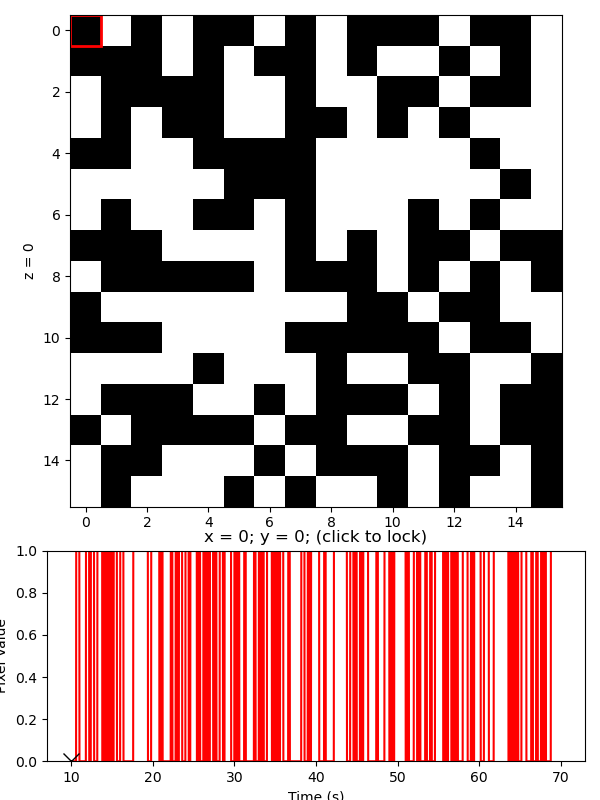

In [5]:
raw_noise_plot = StackExplorer(
    raw_noise,
    zaxis=noise_xaxis,
    delta=10,
    roi_sz=1,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)
raw_noise_plot.ax[1].set_xlabel("Time (s)")
raw_noise_plot.ax[1].set_ylabel("Pixel Value")

raw_noise_plot.fig.show()

### List tiff files found in the directory indicated by `data_path`

#### Note:
**DD ->** distal. **X** 71.7um, **Y** 28.94um

**PD ->** proximal. **X** 71.7um, **Y** 30.9um

In [6]:
fnames = [
    f for f in os.listdir(data_path) 
    if (f.endswith(".tiff") or f.endswith(".tif"))
]

print("files:")
for f in fnames:
    print("  %s" % f)

files:


### Select (and display) recording to analyse here.
Set `ex_name` to the name shared by the desired `.tif` (found in `data_path`) and the `.h5` (found in `s2p_path`). Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackExplorer`). While moving around the ROI, one may left-click to lock it in the current position, allowing interaction with the z-projection axis underneath.

In [7]:
ex_name = "400um"
with h5.File(os.path.join(s2p_path, ex_name + ".h5"), "r") as f:
    ex_s2p = unpack_hdf(f)
    
# physical dimensions (in microns)
rec_width = 71.7
rec_height = 28.94

In [8]:
shared_keys = {"denoised", "masks", "pixels"}

names = [n for n in ex_s2p.keys() if n not in shared_keys]
trials = {i: ex_s2p[n] for i, n in enumerate(names)}

recs = np.stack([ex_s2p[n]["recs"] for n in names], axis=0)
fneu = np.stack([ex_s2p[n]["Fneu"] for n in names], axis=0)
n_trials, n_rois, n_pts = recs.shape

tiff_path = os.path.join(data_path, "200um")

stacks = np.stack(
    [
        io.imread(os.path.join(tiff_path, f))
        for f in os.listdir(tiff_path) 
        if (f.endswith(".tiff") or f.endswith(".tif"))
    ],
    axis=0
)

recs_xaxis = np.arange(stacks.shape[1]) * 0.05  # 20Hz sampling rate

<IPython.core.display.Javascript object>


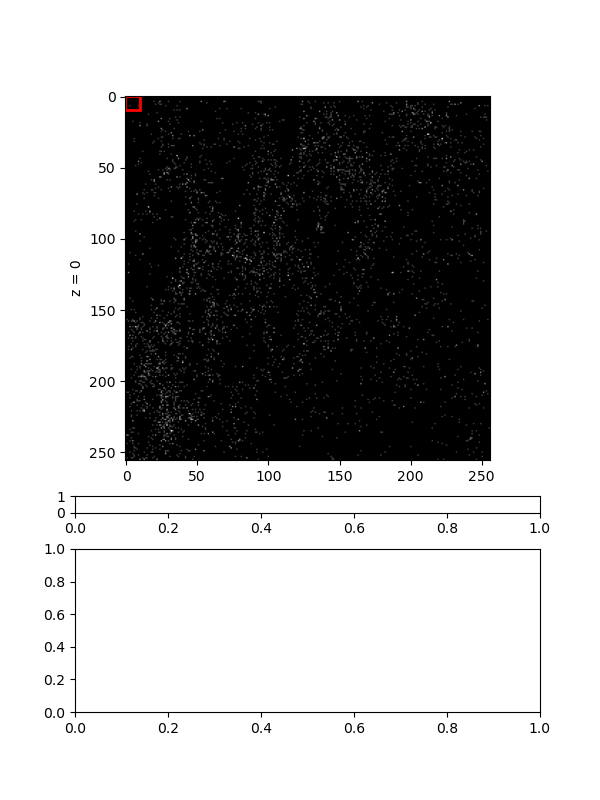

Recording shape: (1700, 256, 256)


In [9]:
stacks = np.stack(
    [
        io.imread(os.path.join(tiff_path, f))
        for f in os.listdir(tiff_path) 
        if (f.endswith(".tiff") or f.endswith(".tif"))
    ],
    axis=0
)

stacks_plot = StackExplorer(
    stacks,
    zaxis=recs_xaxis,
    delta=5,
    roi_sz=10,
    vmin=0,
    figsize=(6, 8)
)
stacks_plot.ax[1].set_xlabel("Time (s)")
stacks_plot.ax[1].set_ylabel("Pixel Value")

print("Recording shape:", stacks[0].shape)
stacks_plot.fig.show()

### Pixel map ROIs generated by suite2p
Use scroll wheel to cycle through ROIs.

<IPython.core.display.Javascript object>


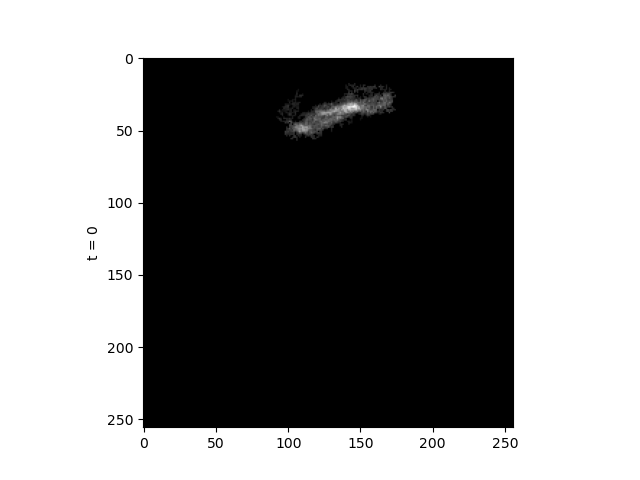

In [10]:
mask_stack = ex_s2p["masks"].transpose(2, 0, 1)
mask_stack_fig, mask_stack_ax = plt.subplots(1)
mask_stack_plot = StackPlotter(
    mask_stack_fig,
    mask_stack_ax,
    mask_stack,
    delta=1
)
mask_stack_fig.show()

### Denoise and signal-noise normalize ROI responses

In [11]:
# subtract out extracted neuropil signal (denoising)
# recs = recs - fneu * 0.7

# normalize to noise and remove offset
recs /= np.var(recs[:, :, 40:198], axis=2).reshape(*recs.shape[:2], 1)
recs -= np.mean(recs[:, :, 40:198], axis=2).reshape(*recs.shape[:2], 1)

### Explore signals from ROIs, and peak finding parameters
Use scroll wheel to cycle between ROIs, and the input boxes below to
adjust parameters for the peak finding algorithm (see `scipy.signal.find_peaks` for more documentation).

- **prominence:** target difference between a peak and its surrounding mean
- **width:** number of points the value must remain within the fractional **tolerance** range of the peak in order to be considered
- **distance:** minimum allowable interval between peak candidates

In [12]:
peak_explorer = PeakExplorer(
    recs_xaxis, 
    recs[0],
    prominence=1,
    width=2,
    tolerance=.5,
    distance=1
)

<IPython.core.display.Javascript object>

### Create response triggered average of stimulus movie, and use a rough transformation of the cell ROI to calculate the average intensity over time.
- `roi_idx` sets the ROI used to generate the triggered stimulus. Make use of the mask and beam scrollers above to pick out ROIs that you might want to do this with
- `lead` sets the time (in seconds) to use preceding each threshold passing event.
- peak finding parameters correspond to those above, set them here in order to influence the stimulus triggered window calculation.
- `max_prominence` sets a clip off point for peaks, such that errantly large events do not completely wash out the rest (due to prominence scaling using softmax). This is optional, and can be set to `None` or commented out from the arguments given to `avg_trigger_window`.

The dotted blue outline represents the relative postion and size of the recording scan field. This can be removed by simply changing the value in the conditional to `0` (or `False`). 

In [17]:
roi_idx = 44
lead = 1.2  # length of triggered average movie (seconds before peak)

prominence = 1.5         # difference between peaks and their surroundings
peak_width = 2         # minimum number of points (within tolerance)
peak_tolerance = .5    # ratio value can drop from peak within width
min_peak_interval = 1  # number of points required between peaks
max_prominence = 4     # clip to avoid dominance by errant peaks
start_time = 30        # time to begin using peaks for triggered average
end_time = None        # cutoff time for considering peaks

lead_frames = nearest_index(noise_xaxis, np.min(noise_xaxis) + lead)
blank_window = np.zeros((n_trials, lead_frames, noise_cols, noise_rows))
lead_stacks, legal_idxs = [], []

for i in range(n_rois): 
    peak_idxs, peak_proms = find_peaks(
        recs[:, i],
        prominence=prominence,
        width=peak_width,
        rel_height=peak_tolerance,
        distance=min_peak_interval
    )
    
    windows, legals = [], []
    for j in range(n_trials):
        trig, idxs = avg_trigger_window(
            noise_xaxis, 
            raw_noise,
            recs_xaxis,
            recs[j][i],
            lead,
            peak_idxs[j],
            prominences=peak_proms[j],
            max_prominence=max_prominence,
            nonlinear_weighting=True,
            start_time=start_time,
            end_time=end_time,
        )
        windows.append(trig)
        legals.append(idxs)
    legal_idxs.append(legals)
    
    # if there are any trials without triggers, replace with blank
    if all(map(lambda l: len(l) > 0, legals)):
        lead_stacks.append(np.stack(windows, axis=0))
    else:
        lead_stacks.append(blank_window)
        
# shape is [n_rois, n_trials, lead_frames, n_cols, n_rows]
lead_stacks = np.stack(lead_stacks, axis=0)
mean_lead_stacks = np.mean(lead_stacks, axis=1)
lead_xaxis = np.linspace(lead_frames * (-1 / 60), 0, lead_frames)

number of peaks used: [61, 105, 88]


<IPython.core.display.Javascript object>


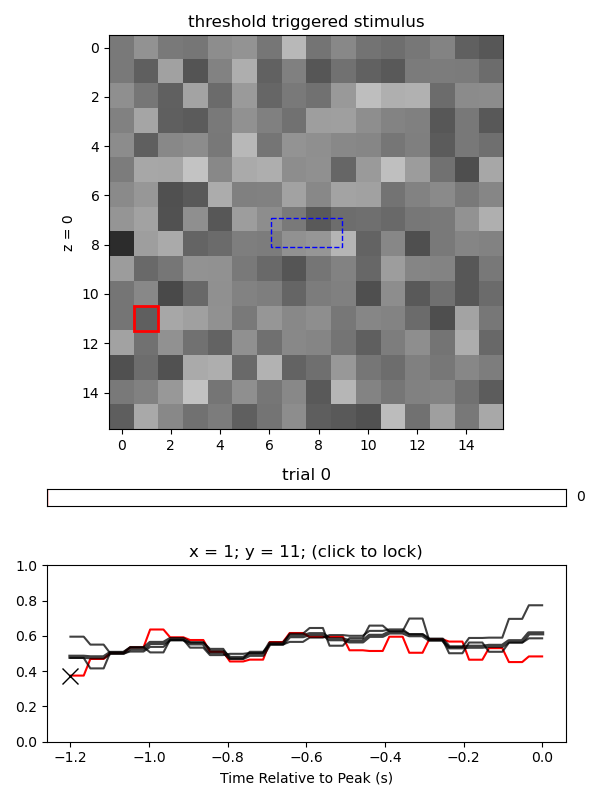

In [19]:
roi_idx = 44
n_legals = [len(l) for l in legal_idxs[roi_idx]]
print("number of peaks used:", n_legals)

lead_stack_plot = StackExplorer(
    lead_stacks[roi_idx],
    zaxis=lead_xaxis,
    delta=1,
    roi_sz=1,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)
lead_stack_plot.stack_ax.set_title("threshold triggered stimulus")
lead_stack_plot.beam_ax.set_xlabel("Time Relative to Peak (s)")
lead_stack_plot.fig.tight_layout()

# outline of scan field (guide for where to look for receptive field)
# NOTE: PD scans are offset (stims is centered to DD scan field)
if 1:
    x_corner_phys = (stim_width - rec_width) / 2
    y_corner_phys = (stim_height - rec_height) / 2
    x_corner_scaled = x_corner_phys / stim_width * raw_noise.shape[2]
    y_corner_scaled = y_corner_phys / stim_height * raw_noise.shape[1]

    field = Rectangle(
        (x_corner_scaled - .5, y_corner_scaled - .5),  # grid offset
        rec_width / stim_width * raw_noise.shape[2], 
        rec_height / stim_height * raw_noise.shape[1], 
        fill=False,
        color="blue",
        linewidth=1,
        linestyle="--"
    )
    lead_stack_plot.ax[0].add_patch(field)

lead_stack_plot.fig.show()

### Rough "receptive field" map via response vs baseline subtraction

<IPython.core.display.Javascript object>


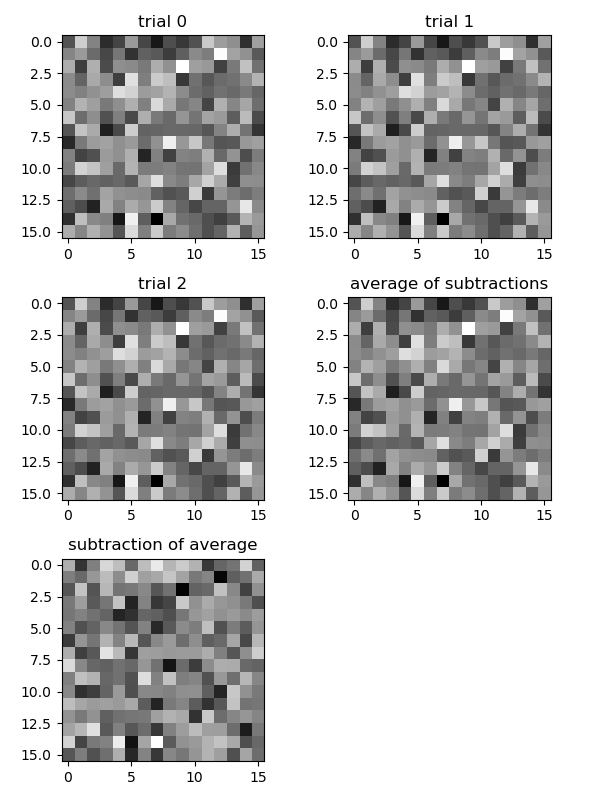

In [20]:
# bsln_t0 = -.500
# bsln_t1 = -.400
# resp_t0 = -.250
# resp_t1 = -.150

# bsln_t0 = -.200
# bsln_t1 = -.150
# resp_t0 = -.75
# resp_t1 = -.25

bsln_t0 = -.400
bsln_t1 = -.350
resp_t0 = -.150
resp_t1 = -.100

bsln_mask = (bsln_t0 <= lead_xaxis) * (lead_xaxis <= bsln_t1)
bsln = np.mean(lead_stacks[roi_idx, :, bsln_mask], axis=1)
resp_mask = (resp_t0 <= lead_xaxis) * (lead_xaxis <= resp_t1)
resp = np.mean(lead_stacks[roi_idx, :, resp_mask], axis=1)

sub = resp - bsln
avg_sub = np.mean(sub, axis=0)
vmin = np.min(sub)
vmax = np.max(sub)

avg_lead_bsln = np.mean(mean_lead_stacks[roi_idx, bsln_mask], axis=0)
avg_lead_resp = np.mean(mean_lead_stacks[roi_idx, resp_mask], axis=0)
avg_lead_sub = avg_lead_bsln - avg_lead_resp

ntrials = sub.shape[0]
ncols = 2
nrows = np.ceil((ntrials + 2) / ncols).astype(np.int)
sub_field_fig, sub_field_ax = plt.subplots(nrows, ncols, figsize=(6, 8))
i = 0
for row in sub_field_ax:
    for a in row:
        if i < ntrials:
            a.imshow(sub[i], cmap="gray", vmin=vmin, vmax=vmax)
            a.set_title("trial %i" % i)
        elif i == ntrials:
            a.imshow(avg_sub, cmap="gray", vmin=vmin, vmax=vmax)
            a.set_title("average of subtractions")
        elif i == ntrials + 1:
            a.imshow(avg_lead_sub, cmap="gray", vmin=vmin, vmax=vmax)
            a.set_title("subtraction of average")
        else:
            a.set_visible(False)
        i += 1
        
sub_field_fig.tight_layout()

### Randomly triggered stimulus for comparison

Sampling N windows from the stimulus randomly, where N is the number of peaks found in the target ROI above (trial with lowest number of legal peaks is used). This is presented for comparison to get a feel for how variable the averages are with this number of samples, as well as to see how often "receptive field" like signals emerge by chance. 

<IPython.core.display.Javascript object>


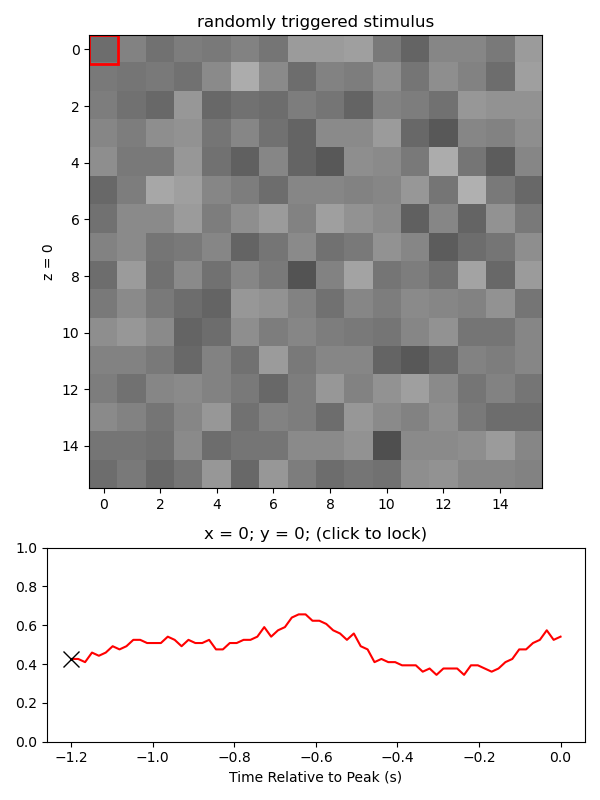

In [21]:
ts = np.random.uniform(
    low=(np.min(noise_xaxis) + lead), 
    high=np.max(noise_xaxis),
    size=min(n_legals)
)
random_lead_stack = np.mean([
    lead_window(noise_xaxis, raw_noise, t, lead) for t in ts
], axis=0)

random_lead_stack_plot = StackExplorer(
    random_lead_stack,
    zaxis=lead_xaxis,
    delta=1,
    roi_sz=1,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)
random_lead_stack_plot.ax[0].set_title("randomly triggered stimulus")
random_lead_stack_plot.ax[1].set_xlabel("Time Relative to Peak (s)")
random_lead_stack_plot.fig.tight_layout()

<IPython.core.display.Javascript object>


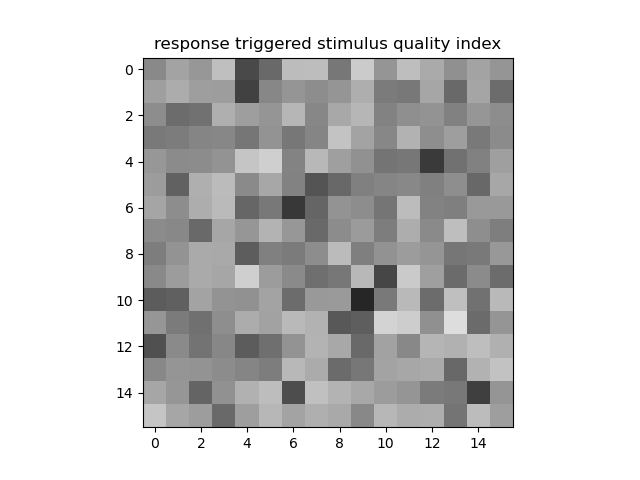

Text(0.5, 1.0, 'response triggered stimulus quality index')

In [23]:
triggered_qi = (
    np.var(mean_lead_stacks[roi_idx], axis=0)
    / np.var(lead_stacks[roi_idx], axis=1).mean(axis=0)
)
trig_qi_fig, trig_qi_ax = plt.subplots(1)
trig_qi_ax.imshow(triggered_qi, cmap="gray", vmin=0, vmax=1)
trig_qi_ax.set_title("response triggered stimulus quality index")

### Comparison of recording stack scale to noise stimulus.

<IPython.core.display.Javascript object>


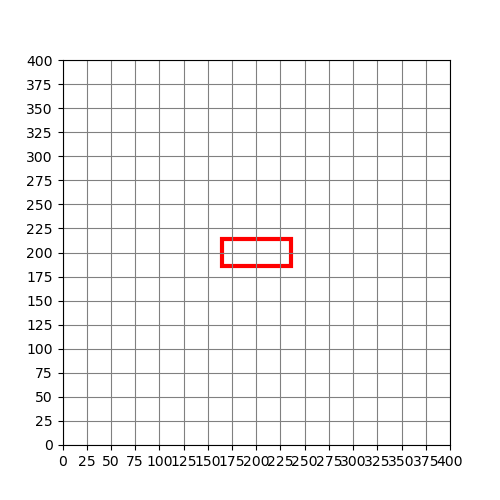

In [17]:
x_corner = (stim_width - rec_width) / 2
y_corner = (stim_height - rec_height) / 2

dims_fig, dims_ax = plt.subplots(1, figsize=(5, 5))
dims_ax.set_ylim(0, stim_height)
dims_ax.set_xlim(0, stim_width)
field = Rectangle(
    (x_corner, y_corner),
    rec_width, 
    rec_height,
    fill=False,
    color="red",
    linewidth=3,
)
dims_ax.add_patch(field)

x_loc = plticker.MultipleLocator(base=(stim_width / 16))
y_loc = plticker.MultipleLocator(base=(stim_height / 16))
dims_ax.xaxis.set_major_locator(x_loc)
dims_ax.yaxis.set_major_locator(y_loc)
dims_ax.grid(which='major', axis='both', linestyle='-', c="grey")

### Compare raw and filtered responses for ROIs
Use scroll wheel over the figure to cycle through ROIs. Threshold for highlighted events can be set with `thresh` variable. This just provides a visual, and does not impact further analysis later on.

<IPython.core.display.Javascript object>


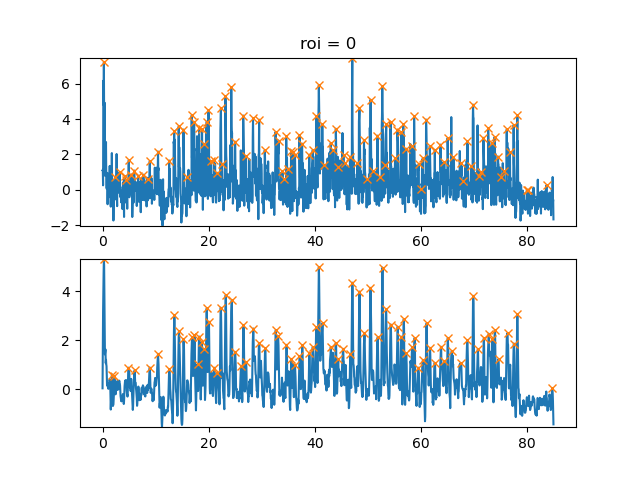

In [18]:
trial = 0
filtered = np.stack(
#     [butter_bandpass_filter(roi, 0.0001, 1, 10) for roi in recs[trial]],
    [signal.savgol_filter(roi, 9, 2) for roi in recs[trial]],
#     [moving_avg(roi, 7) for roi in recs[trial]],
    axis=0
)

beam_idx = 0  # here to be manipulated by beams_onscroll, leave as is
n_beams = filtered.shape[0]
thresh = 1
peak_width = 2
peak_tolerance = .5
min_peak_interval = 1

raw_peaks, _ = signal.find_peaks(recs[trial, beam_idx], height=thresh)
filt_peaks, _ = signal.find_peaks(filtered[beam_idx], height=thresh)
beams_fig, beams_ax = plt.subplots(2)
lines = [
    [
        beams_ax[0].plot(recs_xaxis, recs[trial, beam_idx]),
        beams_ax[0].plot(recs_xaxis[raw_peaks], recs[trial, beam_idx, raw_peaks], "x"),
    ],
    [ 
        beams_ax[1].plot(recs_xaxis, filtered[beam_idx]),
        beams_ax[1].plot(recs_xaxis[filt_peaks], filtered[beam_idx, filt_peaks], "x"),
    ]
]

beams_ax[0].set_ylim(recs[trial].min(), recs[trial].max())
beams_ax[1].set_ylim(filtered.min(), filtered.max())

def beams_update():
    beams_ax[0].set_title("roi = %i" % beam_idx)
    for ax, ln, data in zip(beams_ax, lines, [recs[trial], filtered]):
        ln[0][0].set_ydata(data[beam_idx])
        peaks, _ = signal.find_peaks(
            data[beam_idx],
            prominence=thresh,
            rel_height=peak_tolerance,
            width=peak_width,
            distance=min_peak_interval
        )                             
        ln[1][0].set_data(recs_xaxis[peaks], data[beam_idx, peaks])
        ax.set_ylim(data[beam_idx].min(), data[beam_idx].max())
        beams_fig.canvas.draw()
        

def beams_onscroll(event):
    global beam_idx
    if event.button == "up":
        beam_idx = (beam_idx + 1) % n_beams
    else:
        beam_idx = (beam_idx - 1) % n_beams
    beams_update()


beams_fig.canvas.mpl_connect("scroll_event", beams_onscroll)
beams_update()
beams_fig.show()

In [19]:
def correlation_lags(in1_len, in2_len, mode='full'):
    """Copied from:
    https://github.com/scipy/scipy/blob/v1.6.0/scipy/signal/signaltools.py#L286
    Not present in the installed version of scipy.signal 
    """
    if mode == "full":
        lags = np.arange(-in2_len + 1, in1_len)
    elif mode == "same":
        lags = np.arange(-in2_len + 1, in1_len)
        mid = lags.size // 2
        lag_bound = in1_len // 2
        if in1_len % 2 == 0:
            lags = lags[(mid-lag_bound):(mid+lag_bound)]
        else:
            lags = lags[(mid-lag_bound):(mid+lag_bound)+1]
    elif mode == "valid":
        lag_bound = in1_len - in2_len
        if lag_bound >= 0:
            lags = np.arange(lag_bound + 1)
        else:
            lags = np.arange(lag_bound, 1)
    return lags

<IPython.core.display.Javascript object>


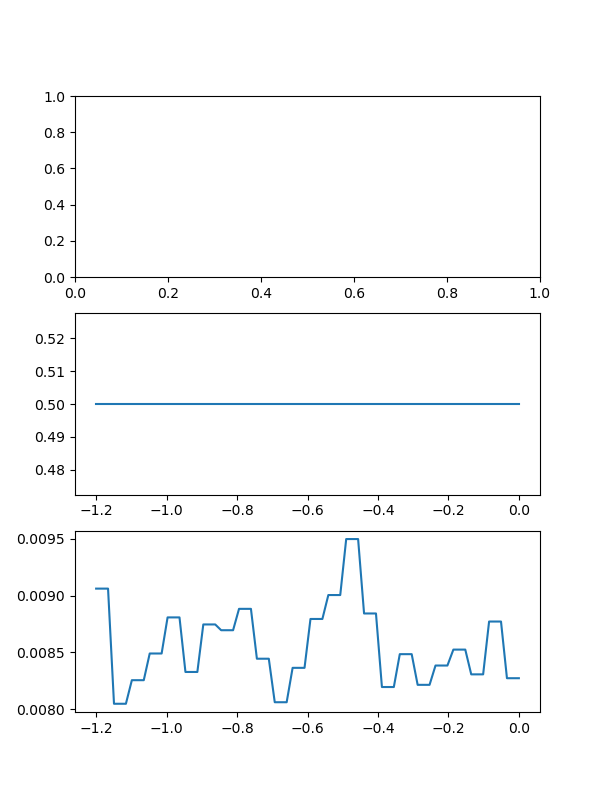

In [20]:
fig_, ax_ = plt.subplots(3, figsize=(6, 8))

# for t in range(lead_stacks.shape[0]):
#     for r in range(lead_stacks.shape[2]):
#         for c in range(lead_stacks.shape[3]):
#             ax_[0].plot(lead_xaxis, lead_stacks[t, :, r, c], alpha=.05, c="black")
    
ax_[1].plot(lead_xaxis, lead_stacks.mean(axis=(0, 2, 3)))
ax_[2].plot(lead_xaxis, lead_stacks.var(axis=(0, 2, 3)))

<IPython.core.display.Javascript object>


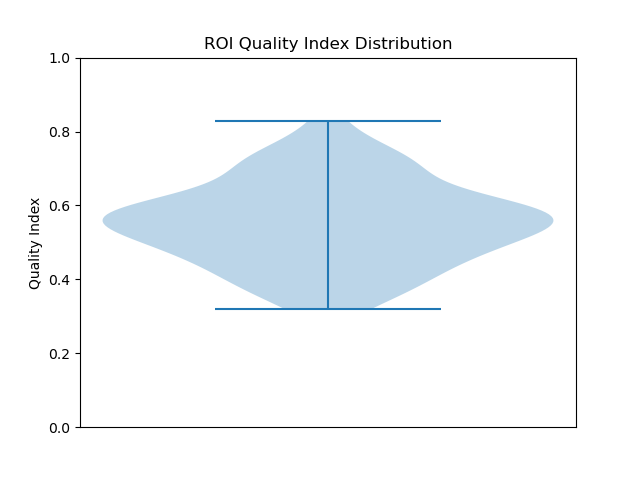

In [21]:
def quality_index(arr, trial_ax=0, data_ax=-1):
    m = np.mean(arr, axis=trial_ax)
    return ( 
        np.var(m, axis=data_ax) 
        / np.var(arr, axis=data_ax).mean(axis=trial_ax)
    )

roi_qi = quality_index(recs)
roi_qi_fig, roi_qi_ax = plt.subplots(1)
roi_qi_ax.violinplot(roi_qi)
roi_qi_ax.set_ylim(0, 1)
roi_qi_ax.set_ylabel("Quality Index")
roi_qi_ax.set_title("ROI Quality Index Distribution")
roi_qi_ax.set_xticks([])
roi_qi_fig.show()

<IPython.core.display.Javascript object>


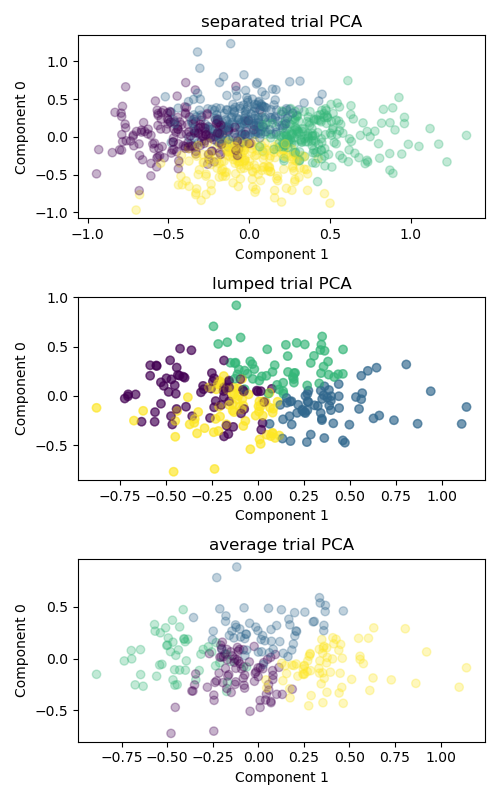

In [22]:
pca = PCA()
k = 4
start_frame = 0

trunc_lead_stacks = lead_stacks[:, start_frame:]
trunc_mean_lead_stack = mean_lead_stack[start_frame:]

reduced_trig_separate = np.concatenate(
    [
        pca.fit_transform(t.reshape(t.shape[0], -1).T)
        for t in trunc_lead_stacks
    ],
    axis=0
)
_, sep_k_lbls, _ = cluster.k_means(reduced_trig_separate, k)

reduced_trig_lumped = pca.fit_transform(
    trunc_lead_stacks.reshape(trunc_lead_stacks.shape[1], -1).T
)
_, lump_k_lbls, _ = cluster.k_means(reduced_trig_lumped, k)

reduced_trig_avg = pca.fit_transform(
    trunc_mean_lead_stack.reshape(trunc_mean_lead_stack.shape[0], -1).T
)
_, avg_k_lbls, _ = cluster.k_means(reduced_trig_avg, k)

pca_trig_fig, pca_trig_ax = plt.subplots(3, figsize=(5, 8))
pca_trig_ax[0].scatter(
    reduced_trig_separate[:, 0],
    reduced_trig_separate[:, 1],
    alpha=.3,
    c=sep_k_lbls,
)
pca_trig_ax[1].scatter(
    reduced_trig_lumped[:, 0],
    reduced_trig_lumped[:, 1],
    alpha=.3,
    c=lump_k_lbls,
)
pca_trig_ax[2].scatter(
    reduced_trig_avg[:, 0],
    reduced_trig_avg[:, 1],
    alpha=.3,
    c=avg_k_lbls,
)
pca_trig_ax[0].set_title("separated trial PCA")
pca_trig_ax[1].set_title("lumped trial PCA")
pca_trig_ax[2].set_title("average trial PCA")
for a in pca_trig_ax:
    a.set_ylabel("Component 0")
    a.set_xlabel("Component 1")
pca_trig_fig.tight_layout()

<IPython.core.display.Javascript object>


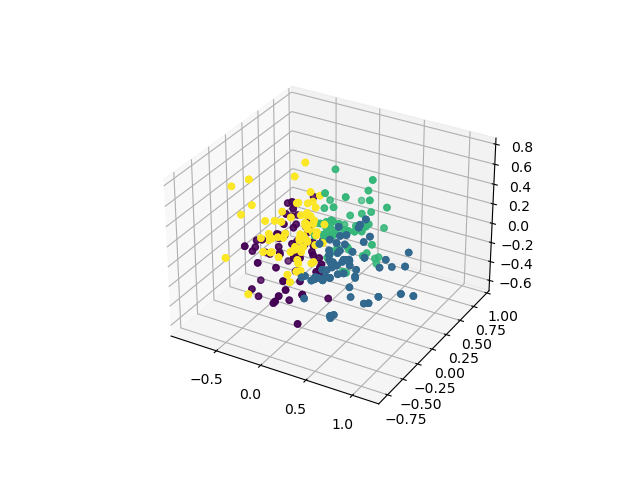

In [23]:
pca_3d_trig_fig = plt.figure()
pca_3d_trig_ax = pca_3d_trig_fig.add_subplot(111, projection='3d')

pca_3d_trig_ax.scatter(
    reduced_trig_lumped[:, 0],
    reduced_trig_lumped[:, 1],
    reduced_trig_lumped[:, 2],
    c=lump_k_lbls,
)

<IPython.core.display.Javascript object>


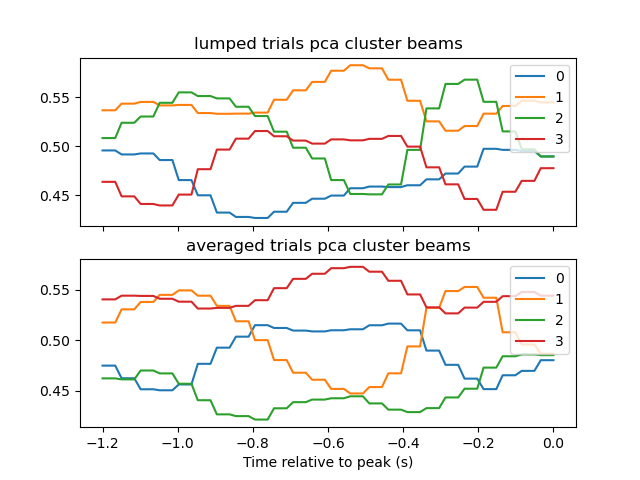

lump groups: [204, 189, 168, 207]
avg groups: [78, 59, 50, 69]


In [24]:
lead_stacks_flat = lead_stacks.transpose(0, 2, 3, 1).reshape(
    lead_stacks.shape[0] * lead_stacks.shape[2] * lead_stacks.shape[3],
    -1
)
lump_cluster_beams = [
    np.mean(lead_stacks_flat[lump_k_lbls == i], axis=0) 
    for i in range(k)
]
avg_cluster_beams = [
    np.mean(
        mean_lead_stack.reshape(lead_frames, -1).T[avg_k_lbls == i], 
        axis=0
    ) 
    for i in range(k)
]

cluster_beams_fig, cluster_beams_ax = plt.subplots(2, sharex=True)
for i, (lb, ab) in enumerate(zip(lump_cluster_beams, avg_cluster_beams)):
    cluster_beams_ax[0].plot(lead_xaxis, lb, label="%i" % i)
    cluster_beams_ax[1].plot(lead_xaxis, ab, label="%i" % i)

for a in cluster_beams_ax:
    a.legend()
    
cluster_beams_ax[0].set_title("lumped trials pca cluster beams")
cluster_beams_ax[1].set_title("averaged trials pca cluster beams")
cluster_beams_ax[1].set_xlabel("Time relative to peak (s)")

print("lump groups:", [np.sum(lump_k_lbls == i) for i in range(k)])
print("avg groups:", [np.sum(avg_k_lbls == i) for i in range(k)])

<IPython.core.display.Javascript object>


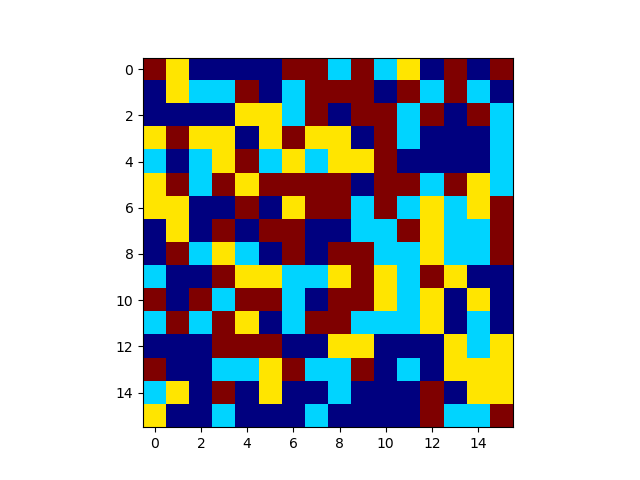

In [25]:
fw, aw = plt.subplots(1)
aw.imshow(avg_k_lbls.reshape(16, 16), cmap="jet")

In [26]:
# fw1, aw1 = plt.subplots(1)
# aw1.imshow(
#     lump_k_lbls.reshape(3, 16, 16).mean(axis=0), 
#     cmap="jet"
# )

In [49]:
def ae_build():
    """"""
    autoencoder = Conv1dDeepClusterer([
        {
            'type': 'conv', 'in': 1, 'out': 64, 'kernel': 11, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 64, 'out': 128, 'kernel': 5, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 128, 'out': 256, 'kernel': 5, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 256, 'out': 128, 'kernel': 9, 'stride': 1,
            'pad': 'valid'
        },
        {'type': 'squeeze'},
        {'type': 'dense', 'in': 128, 'out': 6},
    ])
    return autoencoder


def ae_build2():
    """"""
    autoencoder = Conv1dDeepClusterer([
        {
            'type': 'conv', 'in': 1, 'out': 128, 'kernel': 5, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 128, 'out': 256, 'kernel': 5, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 256, 'out': 128, 'kernel': 18, 'stride': 1,
            'pad': 'valid'
        },
        {'type': 'squeeze'},
        {'type': 'dense', 'in': 128, 'out': 6},
    ])
    return autoencoder

epoch: 0 n_batches: 1
cost: 0.255375
epoch: 1 n_batches: 1
cost: 0.255110
epoch: 2 n_batches: 1
cost: 0.254741
epoch: 3 n_batches: 1
cost: 0.254268
epoch: 4 n_batches: 1
cost: 0.253690
epoch: 5 n_batches: 1
cost: 0.253005
epoch: 6 n_batches: 1
cost: 0.252210
epoch: 7 n_batches: 1
cost: 0.251302
epoch: 8 n_batches: 1
cost: 0.250278
epoch: 9 n_batches: 1
cost: 0.249136
epoch: 10 n_batches: 1
cost: 0.247872
epoch: 11 n_batches: 1
cost: 0.246482
epoch: 12 n_batches: 1
cost: 0.244966
epoch: 13 n_batches: 1
cost: 0.243318
epoch: 14 n_batches: 1
cost: 0.241538
epoch: 15 n_batches: 1
cost: 0.239623
epoch: 16 n_batches: 1
cost: 0.237570
epoch: 17 n_batches: 1
cost: 0.235379
epoch: 18 n_batches: 1
cost: 0.233049
epoch: 19 n_batches: 1
cost: 0.230578
epoch: 20 n_batches: 1
cost: 0.227966
epoch: 21 n_batches: 1
cost: 0.225214
epoch: 22 n_batches: 1
cost: 0.222321
epoch: 23 n_batches: 1
cost: 0.219290
epoch: 24 n_batches: 1
cost: 0.216122
epoch: 25 n_batches: 1
cost: 0.212820
epoch: 26 n_batches: 1

cost: 0.006266
epoch: 214 n_batches: 1
cost: 0.006257
epoch: 215 n_batches: 1
cost: 0.006247
epoch: 216 n_batches: 1
cost: 0.006237
epoch: 217 n_batches: 1
cost: 0.006228
epoch: 218 n_batches: 1
cost: 0.006218
epoch: 219 n_batches: 1
cost: 0.006209
epoch: 220 n_batches: 1
cost: 0.006200
epoch: 221 n_batches: 1
cost: 0.006191
epoch: 222 n_batches: 1
cost: 0.006182
epoch: 223 n_batches: 1
cost: 0.006173
epoch: 224 n_batches: 1
cost: 0.006164
epoch: 225 n_batches: 1
cost: 0.006155
epoch: 226 n_batches: 1
cost: 0.006147
epoch: 227 n_batches: 1
cost: 0.006139
epoch: 228 n_batches: 1
cost: 0.006130
epoch: 229 n_batches: 1
cost: 0.006122
epoch: 230 n_batches: 1
cost: 0.006114
epoch: 231 n_batches: 1
cost: 0.006106
epoch: 232 n_batches: 1
cost: 0.006098
epoch: 233 n_batches: 1
cost: 0.006090
epoch: 234 n_batches: 1
cost: 0.006083
epoch: 235 n_batches: 1
cost: 0.006075
epoch: 236 n_batches: 1
cost: 0.006067
epoch: 237 n_batches: 1
cost: 0.006060
epoch: 238 n_batches: 1
cost: 0.006053
epoch: 239

<IPython.core.display.Javascript object>


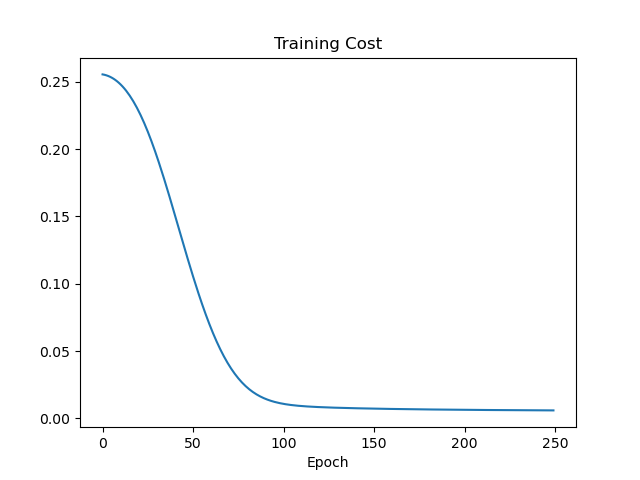

In [64]:
# TODO: Make and autoencoder build here that will fit the size of
# the lead stacks.

# build network
autoencoder = ae_build2()
# autoencoder = builds.ae_build_14()
# autoencoder = ae_build_1()

x = mean_lead_stack.reshape(lead_frames, 1, -1).transpose(2, 1, 0)
# fit network
cost_fig = autoencoder.fit(
    x,
    k, 
    lr=1e-5, 
    epochs=250,
    batch_sz=256,
    cluster_alpha=.01,
    clust_mode='KLdiv',
#     clust_mode='Km',
#     clust_mode='Cal',
    show_plot=True,
)

In [65]:
torch_reduced = autoencoder.get_reduced(x)

hard_centres, hard_clusters, _ = clorch.hard_kmeans(
    torch.from_numpy(torch_reduced), k)
hard_centres = hard_centres.cpu().numpy()
hard_clusters = hard_clusters.cpu().numpy()
print("hard torch groups:", [np.sum(hard_clusters == i) for i in range(k)])

soft_centres, soft_clusters, _ = clorch.soft_kmeans(
    torch.from_numpy(torch_reduced), k)
soft_centres = soft_centres.cpu().numpy()
soft_clusters = soft_clusters.cpu().numpy()
soft_labels = np.argmax(soft_clusters, axis=1)
print("soft torch groups:", [np.sum(soft_labels == i) for i in range(k)])

hard torch groups: [13, 3, 148, 92]
soft torch groups: [154, 94, 0, 8]


<IPython.core.display.Javascript object>


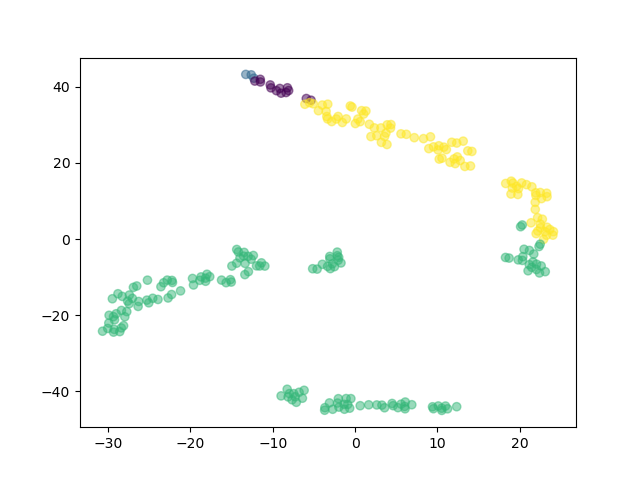

In [66]:
if torch_reduced.shape[1] > 2:
    # also, reduce the cluster centres (TSNE must do all at once)
    reduced_centres = TSNE(
        n_components=2, 
        perplexity=13, 
    ).fit_transform(
        np.concatenate([torch_reduced, hard_centres], axis=0)
    )
    # split samples and centres
    tsne_reduced = reduced_centres[:-hard_centres.shape[0], :]
    tsne_centres = reduced_centres[-hard_centres.shape[0]:, :]
    del reduced_centres

torch_reduced_fig, torch_reduced_ax = plt.subplots(1)

torch_reduced_ax.scatter(
    tsne_reduced[:, 0], 
    tsne_reduced[:, 1], 
    c=hard_clusters, 
    alpha=.5
)

/home/geoff/miniconda3/envs/suite2p/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/geoff/miniconda3/envs/suite2p/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


<IPython.core.display.Javascript object>


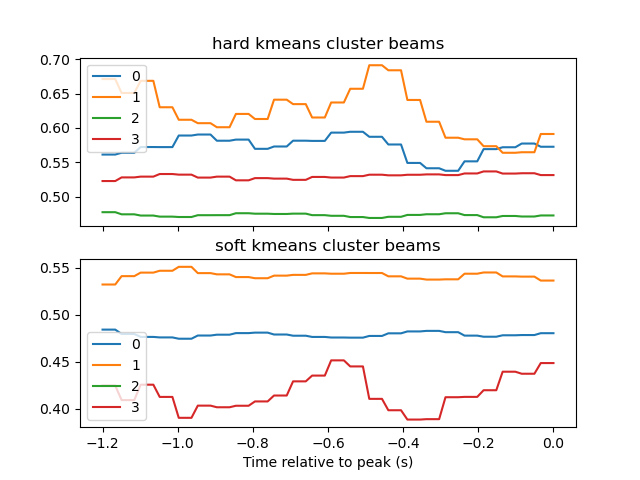

Text(0.5, 0, 'Time relative to peak (s)')

In [67]:
hard_cluster_beams = [
    np.mean(
        mean_lead_stack.reshape(lead_frames, -1).T[hard_clusters == i], 
        axis=0
    ) 
    for i in range(k)
]
soft_cluster_beams = [
    np.mean(
        mean_lead_stack.reshape(lead_frames, -1).T[soft_labels == i], 
        axis=0
    ) 
    for i in range(k)
]

torch_beams_fig, torch_beams_ax = plt.subplots(2, sharex=True)
for i, (hb, sb) in enumerate(zip(hard_cluster_beams, soft_cluster_beams)):
    torch_beams_ax[0].plot(lead_xaxis, hb, label="%i" % i)
    torch_beams_ax[1].plot(lead_xaxis, sb, label="%i" % i)

for a in torch_beams_ax:
    a.legend()
    
torch_beams_ax[0].set_title("hard kmeans cluster beams")
torch_beams_ax[1].set_title("soft kmeans cluster beams")
torch_beams_ax[1].set_xlabel("Time relative to peak (s)")

<IPython.core.display.Javascript object>


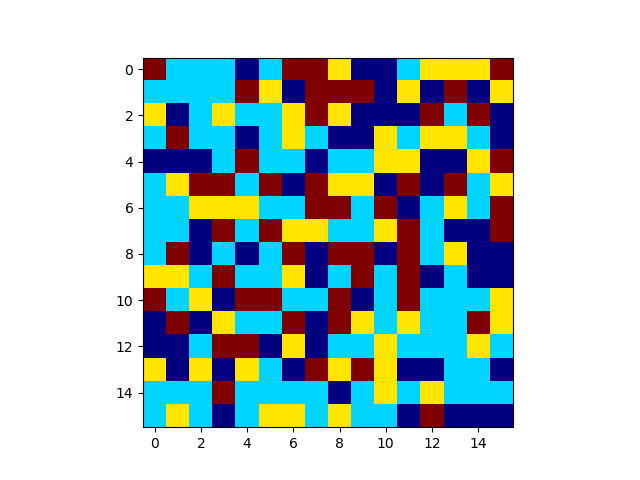

In [63]:
hard_map_fig, hard_map_ax = plt.subplots(1)
hard_map_ax.imshow(hard_clusters.reshape(16, 16), cmap="jet")

/home/geoff/miniconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<IPython.core.display.Javascript object>


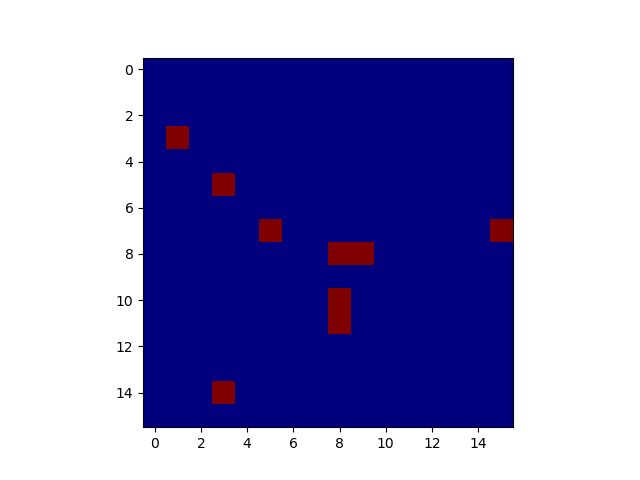

In [33]:
# TODO: This is well suited to scatter plots incorporating the soft
# weights. Since the argmax at the end is not assigning anything to a
# non-response cluster (unlike in hard kmeans), there should be plenty
# of low confidence ones (close in the two active ones, or spread)
# Should help determine whether a threshold of confidence will help
# my cause of reducing this data effectively
soft_map_fig, soft_map_ax = plt.subplots(1)
soft_map_ax.imshow(soft_labels.reshape(16, 16), cmap="jet")

<IPython.core.display.Javascript object>


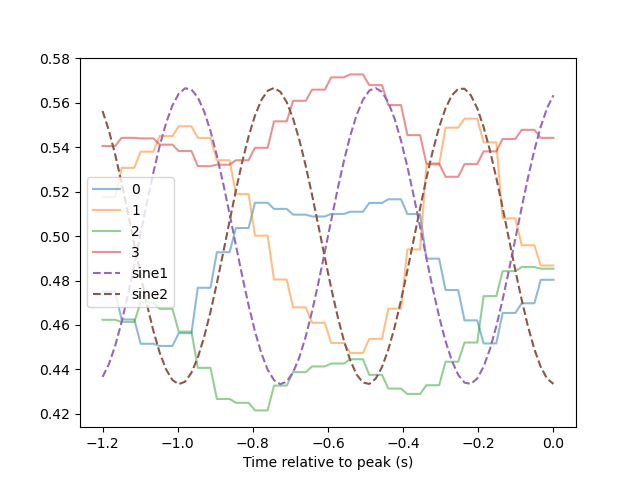

Text(0.5, 0, 'Time relative to peak (s)')

In [34]:
sine_test_fig, sine_test_ax = plt.subplots(1)
for i, b in enumerate(avg_cluster_beams):
    sine_test_ax.plot(lead_xaxis, b, label="%i" % i, alpha=.5)

sine1 = np.sin((lead_xaxis + .1) * 2 * np.pi * 2)
sine2 = np.sin((lead_xaxis + .37) * 2 * np.pi * 2)
early_sine1 = np.concatenate([sine1[:36], np.zeros(36)])
early_sine2 = np.concatenate([sine2[:36], np.zeros(36)])
late_sine1 = np.concatenate([np.zeros(36), sine1[36:]])
late_sine2 = np.concatenate([np.zeros(36), sine2[36:]])
pos_lin = np.arange(lead_frames) / lead_frames - .5
neg_lin = -np.arange(lead_frames) / lead_frames + .5

lines = np.stack(
    [
        sine1, 
        sine2, 
        pos_lin, 
        neg_lin, 
        early_sine1, 
        early_sine2,
        late_sine1, 
        late_sine2,
    ], 
    axis=0
)

sine_test_ax.plot(lead_xaxis, sine1 / 15 + .5, linestyle="--", label="sine1")
sine_test_ax.plot(lead_xaxis, sine2 / 15 + .5, linestyle="--", label="sine2")
# sine_test_ax.plot(lead_xaxis, pos_lin, linestyle="--", label="pos")
# sine_test_ax.plot(lead_xaxis, neg_lin, linestyle="--", label="neg")

# sine_test_ax.set_ylim(.4, .6)
sine_test_ax.legend()
sine_test_ax.set_xlabel("Time relative to peak (s)")

<IPython.core.display.Javascript object>


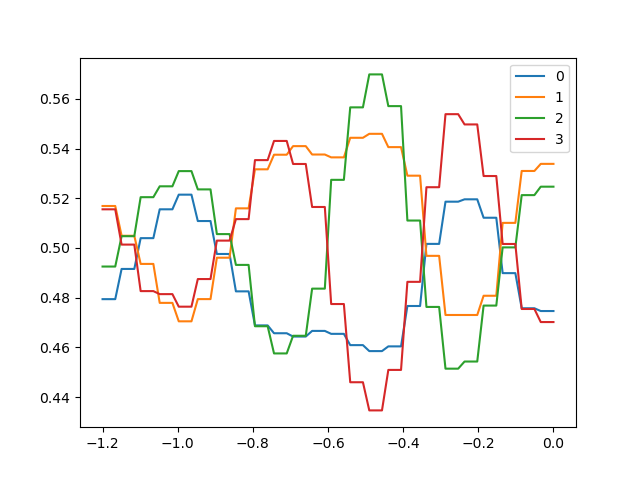

line groups: [79, 69, 53, 55]


In [35]:
s = mean_lead_stack.reshape(lead_frames, -1).T
line_corrs = np.array([
    np.concatenate([np.correlate(b, l) for l in lines])
    for b in s
])
pca_line_corrs = pca.fit_transform(line_corrs)
# pca_line_corrs = pca.fit_transform(
#     np.concatenate([line_corrs, s],axis=1)
# )

kk = 4

line_k_centres, line_k_lbls, _ = cluster.k_means(pca_line_corrs, kk)
line_cluster_beams = [
    np.mean(s[line_k_lbls == i], axis=0) for i in range(kk)
]

line_beams_fig, line_beams_ax = plt.subplots(1)
for i, b in enumerate(line_cluster_beams):
    line_beams_ax.plot(lead_xaxis, b, label="%i" % i)
line_beams_ax.legend()  

print("line groups:", [np.sum(line_k_lbls == i) for i in range(kk)])

<IPython.core.display.Javascript object>


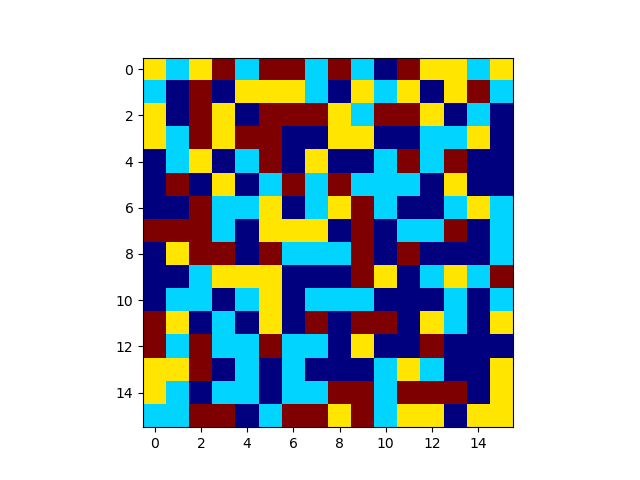

In [36]:
sin_map_fig, sin_map_ax = plt.subplots(1)
sin_map_ax.imshow(line_k_lbls.reshape(16, 16), cmap="jet")

<IPython.core.display.Javascript object>


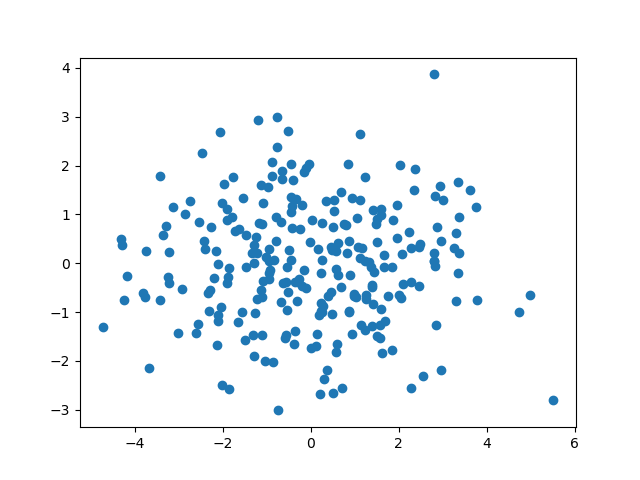

In [37]:
pca_lines_scatter_fig, pca_lines_ax = plt.subplots(1)
pca_lines_ax.scatter(pca_line_corrs[:, 0], pca_line_corrs[:, 1])

<IPython.core.display.Javascript object>


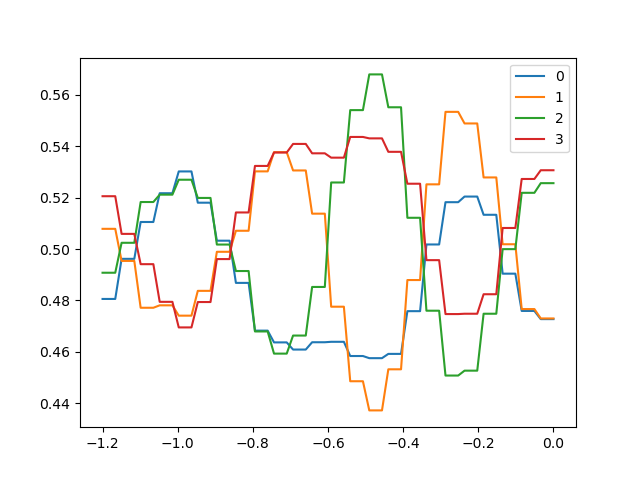

soft line groups: [71, 60, 56, 69]


In [38]:
# NOTE: The argmax of this soft kmeans seems to be pretty close to
# the result from scipy kmeans. Can probably use it in place so I
# don't have to duplicate like this.
soft_line_centres, soft_line_clusters, _ = clorch.soft_kmeans(
    torch.from_numpy(line_corrs), kk)
soft_line_centres = soft_line_centres.cpu().numpy()
soft_line_clusters = soft_line_clusters.cpu().numpy()
soft_line_labels = np.argmax(soft_line_clusters, axis=1)

soft_line_cluster_beams = [
    np.mean(s[soft_line_labels == i], axis=0) for i in range(kk)
]

soft_line_beams_fig, soft_line_beams_ax = plt.subplots(1)
for i, b in enumerate(soft_line_cluster_beams):
    soft_line_beams_ax.plot(lead_xaxis, b, label="%i" % i)
soft_line_beams_ax.legend()  

print(
    "soft line groups:", 
    [np.sum(soft_line_labels == i) for i in range(kk)],
)

<IPython.core.display.Javascript object>


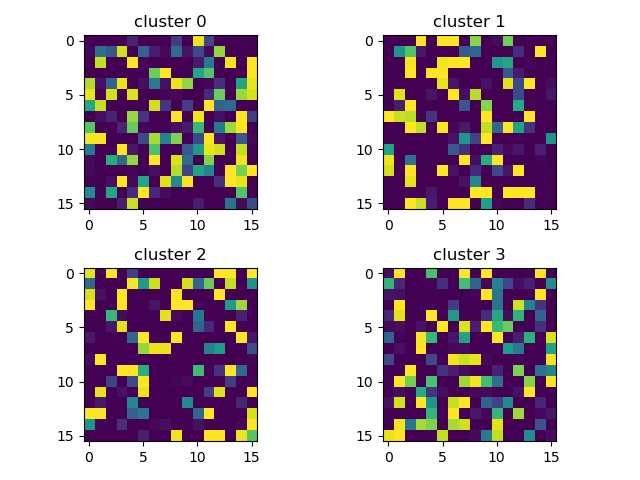

In [39]:
soft_prob_fig, soft_prob_ax = plt.subplots(2, 2)
soft_prob_ax = [a for r in soft_prob_ax for a in r]
for i, a in enumerate(soft_prob_ax):
    a.imshow(
        soft_line_clusters[:, i].reshape(16, 16), 
        vmin=0, 
        vmax=1,
    )
    a.set_title("cluster %i" % i)
    
soft_prob_fig.tight_layout()

In [89]:
nearest_index(noise_xaxis, np.min(noise_xaxis) + 1.2)

72

In [83]:
np.min(noise_xaxis)

70.0

In [86]:
noise_xaxis

70.0

False